# Unsupervised Learning Analysis of Patient Vital Signs

This notebook explores patterns and relationships in patient vital sign data from the MIMIC-IV database using unsupervised learning techniques.

## Purpose
- Identify natural groupings and patterns in patient vital signs
- Discover potential patient subgroups based on vital sign characteristics
- Explore temporal trends in vital sign measurements

## Approach
1. Data preprocessing and aggregation of vital signs (heart rate, respiratory rate, blood pressure, temperature, SpO2)
2. Dimensionality reduction using UMAP for visualization
3. Clustering analysis using K-means and DBSCAN
4. Evaluation of cluster quality and interpretation of results

The analysis focuses on a 5% sample of patients to demonstrate the methodology while maintaining computational efficiency.


In [1]:
# Import required libraries and utilities
# Data handling & visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import umap.umap_ as umap
from tqdm import tqdm

# Scikit-learn components
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid
from joblib import Parallel, delayed

# Custom utilities
from setup_utils import (setup_db_connection, plr, save_intermediate_data,
                            plot_histogram, plot_scatter, plot_line, plot_correlation_matrix)

# Connect to DB and load data
engine = setup_db_connection()
vdf = pd.read_sql_query("""select * from mimiciv.mimiciv_derived.vitalsign""", engine)


c:\Users\steve\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
"""
Data Preprocessing Pipeline
------------------------
1. Extract and transform vital signs data
2. Perform temporal aggregation
3. Sample dataset for computational efficiency
4. Remove statistical outliers
5. Scale features for ML algorithms

Key preprocessing steps:
- Daily aggregation reduces temporal noise
- 5% sampling maintains statistical significance
- IQR-based outlier removal (1.5 * IQR threshold)
- StandardScaler ensures algorithm compatibility
"""

# Define key columns
cols_vitals = ['heart_rate', 'resp_rate', 'mbp', 'temperature', 'spo2']
cols_to_use_time = ['charttime', 'subject_id'] + cols_vitals

# Temporal processing and aggregation
df = vdf[cols_to_use_time].copy()
df['charttime'] = pd.to_datetime(df['charttime'], errors='coerce')
df['charttime'] = df['charttime'].dt.date
df = df.groupby(['subject_id', 'charttime'], as_index=False)[cols_vitals].mean()

# Strategic sampling and outlier removal
unique_subjects = df['subject_id'].unique()
sample_size = int(len(unique_subjects)*0.05)
np.random.seed(42)
sampled_subjects = np.random.choice(unique_subjects, size=sample_size, replace=False)
df = df[df['subject_id'].isin(sampled_subjects)]

# Sample 5% of subjects for demonstration
# - Earlier versions of this notebook sampled 100% of subjects, which severely impacted performance
unique_subjects = df['subject_id'].unique()
sample_size = int(len(unique_subjects)*0.05)
np.random.seed(42)
sampled_subjects = np.random.choice(unique_subjects, size=sample_size, replace=False)
df = df[df['subject_id'].isin(sampled_subjects)]
df = df.dropna()

# IQR Outlier Removal (post-sampling)
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

# Scale
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[cols_vitals])

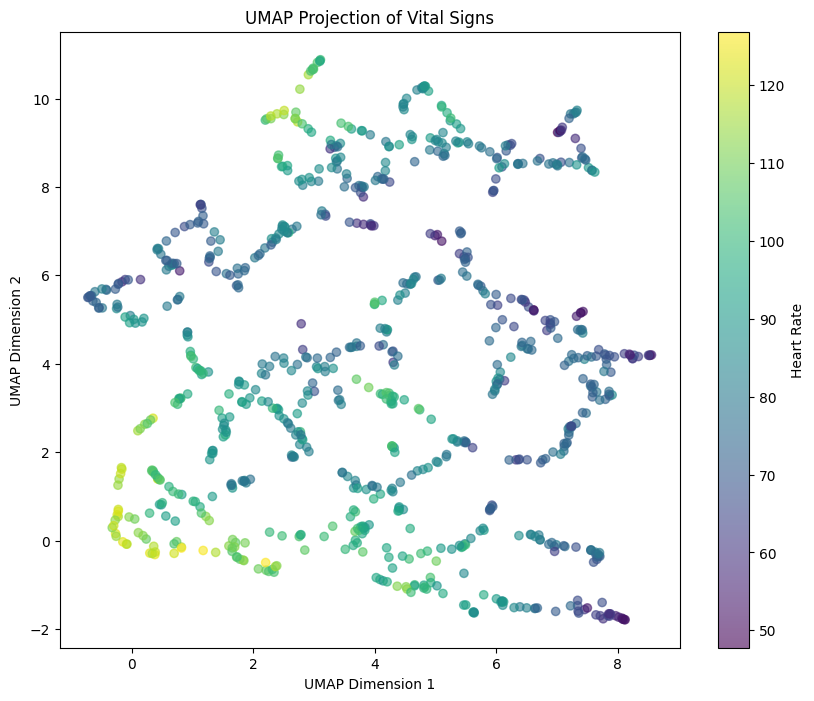

In [11]:
"""
Dimensionality Reduction
----------------------
Applies UMAP for dimensionality reduction and visualization preparation.

Process:
1. Configure UMAP parameters for optimal projection
2. Transform high-dimensional vital signs to 2D space
3. Generate visualization coordinates
4. Prepare data for clustering analysis

Key benefits:
- Preserves both local and global structure
- Handles non-linear relationships effectively
- Provides meaningful clusters for visualization
"""

# UMAP configuration and transformation
reducer = umap.UMAP(
    n_neighbors=5, 
    min_dist=0.05, 
    random_state=42, 
    n_jobs=1
)
embedding = reducer.fit_transform(scaled_data)
df['umap_x'] = embedding[:, 0]
df['umap_y'] = embedding[:, 1]

# Visualize UMAP projection
plt.figure(figsize=(10, 8))
plt.scatter(df['umap_x'], df['umap_y'], 
           c=df['heart_rate'], cmap='viridis', 
           alpha=0.6)
plt.colorbar(label='Heart Rate')
plt.title('UMAP Projection of Vital Signs')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

In [12]:
"""
KMeans Clustering Analysis
-------------------------
Performs KMeans clustering to identify distinct patient groups and potential outliers.

Process:
1. Apply KMeans clustering to scaled data
2. Calculate distances to cluster centroids
3. Identify outliers using distance threshold
4. Add cluster and outlier labels to dataframe

Parameters:
- n_clusters: 3 (optimal from silhouette analysis)
- outlier_threshold: 95th percentile of distances
- random_state: 42 (reproducibility)
"""

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_data)
df['kmeans_cluster'] = kmeans_labels

# Outlier detection using centroid distances
distances = kmeans.transform(scaled_data)
df['distance_to_center'] = [distances[i, lbl] for i, lbl in enumerate(kmeans_labels)]
threshold = np.percentile(df['distance_to_center'], 95)
df['kmeans_outlier'] = df['distance_to_center'] > threshold

In [10]:
"""
DBSCAN Density-Based Clustering
-------------------------
Applies DBSCAN clustering to both raw and UMAP-reduced data for comparison.

Process:
1. Perform DBSCAN on scaled vital signs
2. Apply DBSCAN to UMAP projection
3. Identify noise points as outliers
4. Compare clustering results

Parameters:
- eps: 0.50 (neighborhood radius)
- min_samples: 10 (core point threshold)
- outlier_label: -1 (noise point identifier)
"""

# DBSCAN on raw data
dbscan = DBSCAN(eps=0.50, min_samples=10)
db_labels = dbscan.fit_predict(scaled_data)
df['dbscan_label'] = db_labels
df['dbscan_outlier'] = (db_labels == -1)

# DBSCAN on UMAP-reduced data
dbscan_umap = DBSCAN(eps=0.50, min_samples=10)
umap_labels = dbscan_umap.fit_predict(embedding)
df['umap_dbscan_label'] = umap_labels
df['umap_dbscan_outlier'] = (umap_labels == -1)

In [13]:
"""
UMAP-KMeans Parameter Optimization
--------------------------------
Implements parallel grid search to find optimal UMAP and KMeans parameters.

Process:
1. Evaluate parameter combinations
   - Test UMAP neighborhood configurations
   - Assess different cluster counts
   - Calculate silhouette scores
2. Parallelize computation for efficiency
3. Aggregate and rank results
4. Identify best parameter combination

Parameters searched:
- UMAP:
  - n_neighbors: [2, 3, 4, 5, 6]
  - min_dist: [0.05, 0.1, 0.25, 0.5]
- KMeans:
  - n_clusters: range(2, 10)
"""

def evaluate_combination(data, umap_params, k):
    """
    Evaluates a single UMAP-KMeans parameter combination.

    Args:
        data (np.array): Scaled input data
        umap_params (dict): UMAP parameters (n_neighbors, min_dist)
        k (int): Number of clusters for KMeans

    Returns:
        dict: Parameter combination and its silhouette score
    """
    # UMAP reduction
    reducer = umap.UMAP(
        n_neighbors=umap_params['n_neighbors'],
        min_dist=umap_params['min_dist'],
        random_state=42
    )
    reduced_data = reducer.fit_transform(data)

    # KMeans clustering
    labels = KMeans(n_clusters=k, random_state=42).fit_predict(reduced_data)
    
    # Score calculation
    score = silhouette_score(reduced_data, labels)
    
    return {
        'umap_params': umap_params,
        'k': k,
        'silhouette_score': score
    }

def optimize_parameters(data, umap_param_grid, k_range, n_jobs=-1):
    """
    Performs parallel grid search over UMAP and KMeans parameters.

    Args:
        data (np.array): Scaled input data
        umap_param_grid (dict): Grid of UMAP parameters to search
        k_range (range): Range of cluster counts to test
        n_jobs (int): Number of parallel jobs (-1 for all cores)

    Returns:
        pd.DataFrame: Results of all parameter combinations
    """
    # Generate parameter combinations
    param_combinations = list(ParameterGrid(umap_param_grid))
    
    # Parallel evaluation
    results = Parallel(n_jobs=n_jobs)(
        delayed(evaluate_combination)(data, umap_params, k)
        for umap_params in param_combinations
        for k in k_range
    )
    
    return pd.DataFrame(results)

# Define parameter search space
umap_param_grid = {
    'n_neighbors': [2, 3, 4, 5, 6],
    'min_dist': [0.05, 0.1, 0.25, 0.5]
}
k_range = range(2, 10)

# Execute optimization
results_df = optimize_parameters(scaled_data, umap_param_grid, k_range)

# Find optimal parameters
best_result = results_df.loc[results_df['silhouette_score'].idxmax()]
print("\nOptimal Parameter Configuration:")
print("-" * 30)
print(f"UMAP Parameters: {best_result['umap_params']}")
print(f"Number of Clusters: {best_result['k']}")
print(f"Silhouette Score: {best_result['silhouette_score']:.3f}")


Optimal Parameter Configuration:
------------------------------
UMAP Parameters: {'min_dist': 0.05, 'n_neighbors': 6}
Number of Clusters: 9
Silhouette Score: 0.472


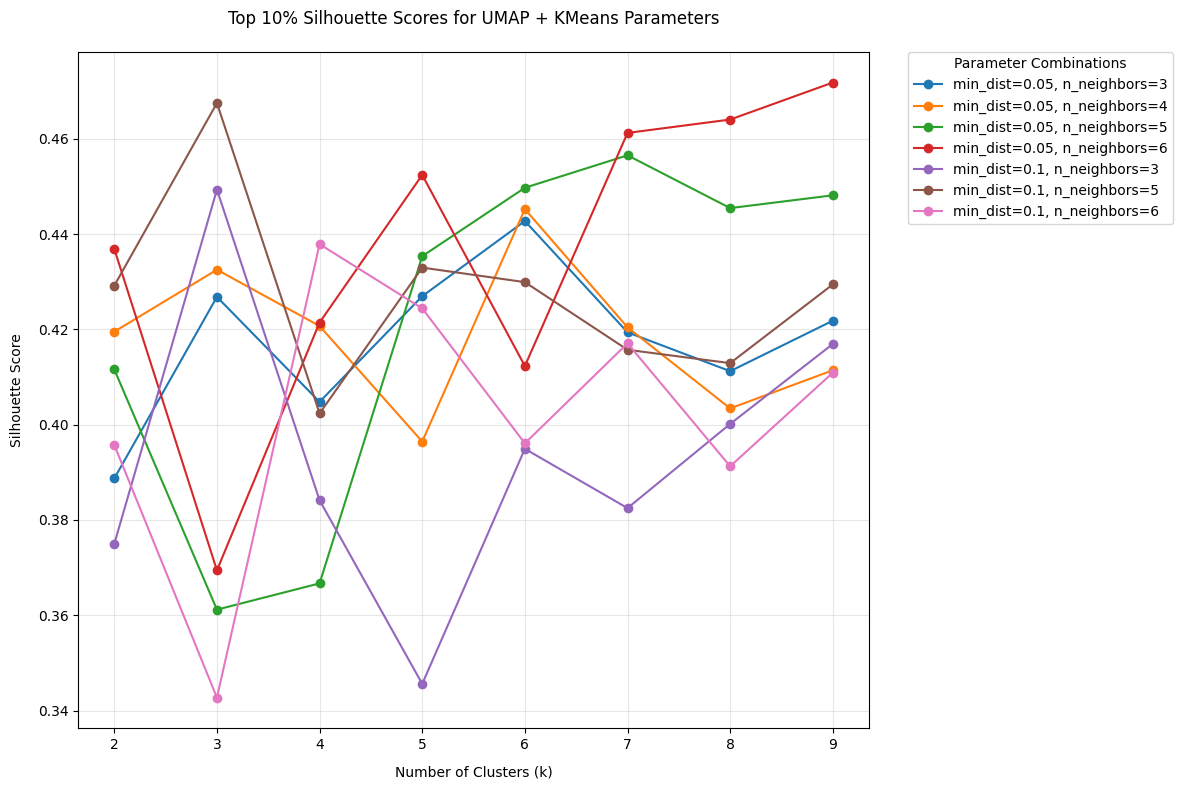


Top Performance Statistics:
------------------------------
Score threshold: 0.433
Parameter combinations meeting threshold: 16
Best score achieved: 0.472

Best Configuration:
UMAP n_neighbors: 6
UMAP min_dist: 0.05
Number of clusters: 9


In [16]:
"""
Silhouette Score Visualization
---------------------------
Visualizes parameter optimization results to identify optimal configurations.

Process:
1. Group results by parameter combinations
2. Filter for top performing combinations
3. Plot silhouette scores across cluster counts
4. Generate comparative visualization

Visualization components:
- Line plots for top parameter combinations
- X-axis: Number of clusters
- Y-axis: Silhouette score
- Color coding by parameter values
"""

def plot_silhouette_scores(results_df, param_grid, top_percent=10):
    """
    Creates visualization of silhouette scores for top performing parameter combinations.
    
    Args:
        results_df (pd.DataFrame): Results from parameter optimization
        param_grid (dict): Grid of parameters used in search
        top_percent (float): Only show combinations with scores in top N%
    """
    plt.figure(figsize=(12, 8))
    
    # Calculate threshold for top performers
    threshold = np.percentile(results_df['silhouette_score'], 100 - top_percent)
    
    # Plot only parameter combinations that achieve top scores
    for min_dist in param_grid['min_dist']:
        subset = results_df[results_df['umap_params'].apply(lambda x: x['min_dist'] == min_dist)]
        for n_neighbors in param_grid['n_neighbors']:
            mask = subset['umap_params'].apply(lambda x: x['n_neighbors'] == n_neighbors)
            param_results = subset[mask]
            
            # Only plot if any scores for this combination are in top percentage
            if any(param_results['silhouette_score'] >= threshold):
                plt.plot(
                    param_results['k'], 
                    param_results['silhouette_score'],
                    marker='o',
                    linestyle='-',
                    label=f"min_dist={min_dist}, n_neighbors={n_neighbors}"
                )
    
    # Configure plot aesthetics
    plt.title(f'Top {top_percent}% Silhouette Scores for UMAP + KMeans Parameters', pad=20)
    plt.xlabel('Number of Clusters (k)', labelpad=10)
    plt.ylabel('Silhouette Score', labelpad=10)
    plt.grid(True, alpha=0.3)
    plt.legend(
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        borderaxespad=0,
        title='Parameter Combinations'
    )
    
    plt.tight_layout()
    plt.show()
    
    return threshold

# Plot only top 10% of parameter combinations
threshold = plot_silhouette_scores(results_df, umap_param_grid)

# Print performance statistics
top_configs = results_df[results_df['silhouette_score'] >= threshold]
best_config = results_df.loc[results_df['silhouette_score'].idxmax()]

print("\nTop Performance Statistics:")
print("-" * 30)
print(f"Score threshold: {threshold:.3f}")
print(f"Parameter combinations meeting threshold: {len(top_configs)}")
print(f"Best score achieved: {best_config['silhouette_score']:.3f}")
print("\nBest Configuration:")
print(f"UMAP n_neighbors: {best_config['umap_params']['n_neighbors']}")
print(f"UMAP min_dist: {best_config['umap_params']['min_dist']}")
print(f"Number of clusters: {best_config['k']}")

In [17]:
"""
Categorizes a data point based on which outlier detection methods flagged it.

Args:
    row: A pandas Series containing boolean flags for each outlier detection method:
        - kmeans_outlier: Whether KMeans identified this as an outlier
        - dbscan_outlier: Whether DBSCAN identified this as an outlier  
        - umap_dbscan_outlier: Whether UMAP+DBSCAN identified this as an outlier

Returns:
    str: A string indicating which methods identified the point as an outlier,
         joined by '&' (e.g. 'KMeans & DBSCAN'). Returns 'No Outlier' if no
         methods flagged the point.
"""
def outlier_category(row):
    km = row['kmeans_outlier']
    db = row['dbscan_outlier']
    ud = row['umap_dbscan_outlier']
    outlier_methods = []
    if km:
        outlier_methods.append('KMeans')
    if db:
        outlier_methods.append('DBSCAN')
    if ud:
        outlier_methods.append('UMAP_DBSCAN')
    if len(outlier_methods) == 0:
        return 'No Outlier'
    return ' & '.join(outlier_methods)

# Apply the outlier_category function to each row in the dataframe
df['outlier_combination'] = df.apply(outlier_category, axis=1)


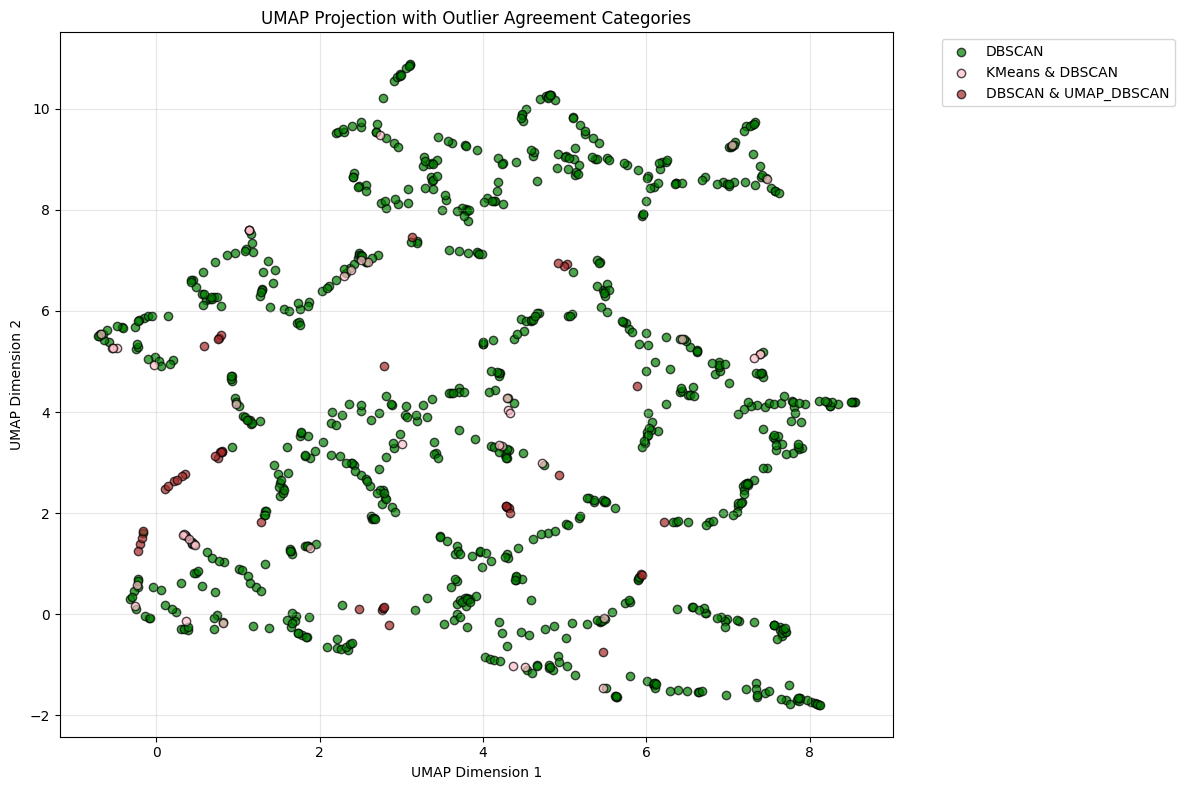


Outlier Detection Summary:
-------------------------
DBSCAN: 785 points (90.0%)
DBSCAN & UMAP_DBSCAN: 43 points (4.9%)
KMeans & DBSCAN: 44 points (5.0%)


In [18]:
"""
Outlier Analysis and Visualization
------------------------------
Combines multiple outlier detection methods and visualizes their agreement.

Process:
1. Aggregate results from all detection methods
2. Create categorical outlier classifications
3. Generate comprehensive outlier visualization
4. Calculate agreement statistics

Detection methods:
- KMeans: Distance-based outlier detection
- DBSCAN: Density-based clustering outliers
- UMAP-DBSCAN: Manifold-aware detection
"""

def get_outlier_combination(kmeans_flag, dbscan_flag, umap_dbscan_flag):
    """
    Creates a categorical label based on which methods flagged an outlier.
    
    Args:
        kmeans_flag (bool): Whether KMeans detected an outlier
        dbscan_flag (bool): Whether DBSCAN detected an outlier
        umap_dbscan_flag (bool): Whether UMAP+DBSCAN detected an outlier
    
    Returns:
        str: Combined category name (e.g., 'KMeans & DBSCAN' or 'No Outlier')
    """
    methods = []
    if kmeans_flag:
        methods.append('KMeans')
    if dbscan_flag:
        methods.append('DBSCAN')
    if umap_dbscan_flag:
        methods.append('UMAP_DBSCAN')
    
    return ' & '.join(methods) if methods else 'No Outlier'

# Apply outlier categorization to dataframe
df['outlier_combination'] = df.apply(
    lambda row: get_outlier_combination(
        row['kmeans_outlier'],
        row['dbscan_outlier'],
        row['umap_dbscan_outlier']
    ), 
    axis=1
)

# Visualization configuration
color_map = {
    'No Outlier': 'lightblue',
    'KMeans': 'orange',
    'DBSCAN': 'green',
    'UMAP_DBSCAN': 'yellow',
    'KMeans & DBSCAN': 'pink',
    'KMeans & UMAP_DBSCAN': 'purple',
    'DBSCAN & UMAP_DBSCAN': 'brown',
    'KMeans & DBSCAN & UMAP_DBSCAN': 'red'
}

# Create visualization
plt.figure(figsize=(12, 8))
for cat in df['outlier_combination'].unique():
    cat_points = df[df['outlier_combination'] == cat]
    plt.scatter(cat_points['umap_x'], 
               cat_points['umap_y'],
               color=color_map[cat],
               alpha=0.7,
               edgecolor='black',
               label=cat)

plt.title('UMAP Projection with Outlier Agreement Categories')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nOutlier Detection Summary:")
print("-" * 25)
for cat in sorted(df['outlier_combination'].unique()):
    count = len(df[df['outlier_combination'] == cat])
    percentage = (count / len(df)) * 100
    print(f"{cat}: {count} points ({percentage:.1f}%)")

---
# Unsupervised Analysis

## Process Summary
- Applied multiple unsupervised outlier detection methods:
  - KMeans clustering
  - DBSCAN clustering
  - UMAP dimensionality reduction + DBSCAN
- Visualized agreement between methods using UMAP projection
- Created an outlier categorization, showing where methods agree/disagree
- Used color coding to distinguish between single method detections and overlapping detections

## Potential Improvements & Pitfalls
- Current approach uses fixed hyperparameters - could implement parameter tuning
- UMAP projection may not perfectly preserve high-dimensional relationships
- No validation metrics for outlier detection accuracy (inherent challenge with unsupervised learning)
- Methods may be sensitive to data scaling/normalization choices
- Current visualization are cluttered with large datasets

## Next Steps
1. Validate findings:
   - Cross-reference detected outliers with domain knowledge
   - Compare results with supervised model results
   - Various scope and ensemble methods could improve quality at scale

2. Enhance methodology:
   - Implement parameter optimization
   - Add additional outlier detection methods (e.g., Isolation Forest, LOF)
   - Explore feature importance in outlier detection

3. Improve visualization:
   - Add interactive plotting capabilities (e.g. plotly, frontend web application)
   - Views focusing on specific detection methods
   - Include summary statistics for each outlier category

4. Production considerations:
   - Streamline pipeline for new data processing
   - Add model persistence capabilities (e.g. joblib, pickle)
   - Implement performance optimization for larger datasets


In [19]:
# # Save intermediate data
# save_intermediate_data(df, 'data/intermediate_unsupervised.csv')
# plr()
# print("Unsupervised processing complete and data saved.")

@25/01/03 13:25:23 Eastern Standard Time
Unsupervised processing complete and data saved.
